In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import ML libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from xgboost import XGBClassifier

import pickle # to save and load pre-trained models

In [2]:
%matplotlib inline

In [3]:
#trades_df = pd.read_csv('buy_signals_backtest_ML_July-Aug2020.dat')
trades_df = pd.read_csv('buy_signals_backtest_ML_Jan2019-Aug2020.dat')
#trades_df.set_index('time_curr', inplace=True)
#trades_df.index=pd.to_datetime(trades_df.index)

In [4]:
trades_df.columns

Index(['time_curr', 'symbol', 'price', 'pattern', 'origin', 'ranging',
       'd_ranging', 'lower', 'upper', 'middle', 'd_lower', 'd_upper',
       'd_middle', 'ema_10', 'ema_200', 'd_ema_10', 'd_ema_200', 'k_15',
       'd_15', 'd_k_15', 'd_d_15', 'stoch_cond_5', 'candle_color', 'vol_inc',
       'dist_to_BB', 'profit', 'elapsed', 'min_price', 'max_price',
       'profit_s15', 'elapsed_s15', 'min_price_s15', 'max_price_s15',
       'Unnamed: 33'],
      dtype='object')

In [5]:
profitability = [0 if item < 0 else 1 for item in trades_df['profit']]
trades_df['profitability'] = profitability
profitability_s15 = [0 if item < 0 else 1 for item in trades_df['profit_s15']]
trades_df['profitability_s15'] = profitability_s15


Convert 'time_curr' to `datetime` object

In [6]:
trades_df['time_curr'] = pd.to_datetime(trades_df['time_curr'])

In [7]:
# Sort the dataframe by the date:
trades_df.sort_values(by=['time_curr'], inplace=True)

In [8]:
trades_df.columns

Index(['time_curr', 'symbol', 'price', 'pattern', 'origin', 'ranging',
       'd_ranging', 'lower', 'upper', 'middle', 'd_lower', 'd_upper',
       'd_middle', 'ema_10', 'ema_200', 'd_ema_10', 'd_ema_200', 'k_15',
       'd_15', 'd_k_15', 'd_d_15', 'stoch_cond_5', 'candle_color', 'vol_inc',
       'dist_to_BB', 'profit', 'elapsed', 'min_price', 'max_price',
       'profit_s15', 'elapsed_s15', 'min_price_s15', 'max_price_s15',
       'Unnamed: 33', 'profitability', 'profitability_s15'],
      dtype='object')

In [9]:
time_span = trades_df.time_curr.iloc[-1] - trades_df.time_curr.iloc[0]
print(f"Total profitability in {time_span}: ", trades_df['profitability'].sum()/len(trades_df['profitability']) )
print("total n trades: ", len(trades_df['profitability']))
print(f"Total profitability in {time_span} with 0.15 stop loss: ", trades_df['profitability_s15'].sum()/len(trades_df['profitability_s15']) )
print("total n trades: ", len(trades_df['profitability_s15']))

Total profitability in 617 days 10:45:00:  0.6138994161630646
total n trades:  39052
Total profitability in 617 days 10:45:00 with 0.15 stop loss:  0.4338318139916009
total n trades:  39052


In [10]:
trades_df.drop(['Unnamed: 33'], axis=1, inplace=True)

In [11]:
trades_df['profitability']

23015    1
23016    1
23017    1
14973    0
22340    1
        ..
9339     1
9340     1
2661     1
10106    1
3250     1
Name: profitability, Length: 39052, dtype: int64

In [12]:
pd.set_option('max_columns',100)

In [13]:
#trades_df.dropna(axis=1, inplace=True)
trades_df.fillna(-9999, inplace=True)

In [14]:
trades_df = trades_df[trades_df.d_ema_200 != -9999]

In [15]:
# Remove the problematic coin that has been identified later
#trades_df = trades_df[trades_df.symbol != 'UMABTC']

In [16]:
trades_df.describe()

,price,ranging,d_ranging,lower,upper,middle,d_lower,d_upper,d_middle,ema_10,ema_200,d_ema_10,d_ema_200,k_15,d_15,d_k_15,d_d_15,vol_inc,dist_to_BB,profit,elapsed,min_price,max_price,profit_s15,elapsed_s15,min_price_s15,max_price_s15,profitability,profitability_s15
count,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,3.867300e+04,3.867300e+04,3.867300e+04,38673.000000,38673.000000,3.867300e+04,3.867300e+04,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000,38673.000000
mean,0.000259,8.132035,0.015274,0.000257,0.000275,0.000266,-6.956378e-08,5.781294e-09,-3.160784e-08,0.000262,0.000265,-5.806764e-08,-4.493574e-09,17.991926,11.614167,0.505600,0.267060,1.315766,3.156596,-0.236328,152.000776,-1.483952,1.519735,-0.198006,75.169265,-0.916117,1.194247,0.614149,0.433998
std,0.000901,4.929595,0.052520,0.000895,0.000954,0.000924,3.697506e-07,1.564281e-07,1.482744e-07,0.000912,0.000928,2.523498e-07,4.049922e-08,6.259305,5.698897,0.269057,0.162142,5.187358,2.017446,2.190608,277.567596,0.980151,1.295275,1.486893,140.239091,0.458446,1.180594,0.486802,0.495631
min,0.000002,4.000000,-1.393000,0.000001,0.000002,0.000002,-1.039000e-05,-6.480000e-06,-3.520000e-06,0.000002,0.000001,-6.850000e-06,-9.500000e-07,10.000000,3.330000,0.000000,0.000000,0.000000,1.500000,-3.000000,1.000000,-2.500000,-4.500000,-1.500000,1.000000,-1.250000,-4.460000,0.000000,0.000000
25%,0.000007,5.227000,0.000000,0.000007,0.000007,0.000007,-3.000000e-08,0.000000e+00,-1.000000e-08,0.000007,0.000007,-2.000000e-08,0.000000e+00,12.220000,6.940000,0.310000,0.150000,0.289000,1.955000,-3.000000,24.000000,-2.500000,0.640000,-1.500000,12.000000,-1.250000,0.320000,0.000000,0.000000
50%,0.000030,6.748000,0.015000,0.000029,0.000032,0.000030,-1.000000e-08,0.000000e+00,-0.000000e+00,0.000030,0.000030,-0.000000e+00,0.000000e+00,16.730000,10.620000,0.490000,0.250000,0.681000,2.579000,1.500000,64.000000,-1.590000,1.550000,-1.500000,32.000000,-1.250000,1.040000,1.000000,0.000000
75%,0.000124,9.356000,0.032000,0.000123,0.000131,0.000127,0.000000e+00,-0.000000e+00,-0.000000e+00,0.000125,0.000126,-0.000000e+00,0.000000e+00,23.290000,15.410000,0.690000,0.370000,1.353000,3.652000,1.500000,162.000000,-0.500000,1.960000,1.500000,80.000000,-0.530000,1.740000,1.000000,1.000000
max,0.008987,307.999000,3.898000,0.008979,0.009661,0.009236,9.100000e-06,7.020000e-06,2.630000e-06,0.009112,0.009531,1.160000e-06,9.800000e-07,30.000000,29.900000,2.000000,0.670000,673.619000,121.406000,1.500000,12083.000000,0.880000,36.020000,1.500000,4617.000000,0.880000,33.920000,1.000000,1.000000


### Now we start preparing the dataset to train a model using various Machine Learning methods

1. Features:

In [17]:
X = trades_df.drop(['symbol','profit',
                    'stoch_cond_5','vol_inc',
       'elapsed', 'min_price', 'max_price', 'profit_s15', 'elapsed_s15',
       'min_price_s15', 'max_price_s15',  'profitability',
       'profitability_s15'], axis=1)

# For the 1st trial, let us also drop all categorical variables:
# X = trades_df.drop(['time_curr','profit',
#                     'pattern','origin','symbol','stoch_cond_5','candle_color',
#        'elapsed', 'min_price', 'max_price', 'profit_s15', 'elapsed_s15',
#        'min_price_s15', 'max_price_s15',  'profitability',
#        'profitability_s15'], axis=1)

In [18]:
#X['stoch_cond_5'] = X['stoch_cond_5'].astype('str')

In [19]:
### Looks like features from timestamps don't help
# X['day'] = X.time_curr.dt.day.astype('uint8')
# X['hour'] = X.time_curr.dt.hour.astype('uint8')
# X['minute'] = X.time_curr.dt.minute.astype('uint8')

In [20]:
X.drop(['time_curr'], axis=1, inplace=True)

In [21]:
X.columns

Index(['price', 'pattern', 'origin', 'ranging', 'd_ranging', 'lower', 'upper',
       'middle', 'd_lower', 'd_upper', 'd_middle', 'ema_10', 'ema_200',
       'd_ema_10', 'd_ema_200', 'k_15', 'd_15', 'd_k_15', 'd_d_15',
       'candle_color', 'dist_to_BB'],
      dtype='object')

In [22]:
# Let's try to drop all prices and keep only the slopes and percentages: (No!)
## X = X.drop(['price', 'lower', 'upper', 'middle', 'ema_10'], axis=1)

In [23]:
for col in ['d_lower', 'd_upper', 'd_middle', 'd_ema_10', 'd_ema_200' ]: X[col] = X[col]*100000

In [24]:
X.head()

,price,pattern,origin,ranging,d_ranging,lower,upper,middle,d_lower,d_upper,d_middle,ema_10,ema_200,d_ema_10,d_ema_200,k_15,d_15,d_k_15,d_d_15,candle_color,dist_to_BB
30297,0.000013,no,upper,7.312,0.019,0.000012,0.000013,0.000013,0.000,0.000,0.000,0.000013,0.000012,0.000,0.000,27.18,16.80,0.85,0.43,green,1.928
22022,0.000076,no,upper,9.851,-0.153,0.000072,0.000081,0.000076,0.006,-0.003,0.002,0.000076,0.000065,-0.001,0.001,10.95,10.45,0.05,0.24,red,6.454
22023,0.000072,Hammer,lower,13.827,0.062,0.000071,0.000080,0.000075,-0.003,-0.001,-0.002,0.000073,0.000066,-0.002,0.000,12.69,7.72,0.35,0.28,green,4.254
22344,0.000013,Harami,lower,6.464,0.026,0.000013,0.000014,0.000013,-0.000,-0.000,-0.000,0.000013,0.000012,-0.000,0.000,21.00,14.84,0.41,0.04,green,2.795
22346,0.000013,no,lower,6.569,0.007,0.000013,0.000014,0.000013,-0.000,-0.000,-0.000,0.000013,0.000012,-0.000,0.000,19.36,17.33,0.10,0.24,red,2.470


2. Target:

Here we predict whether the trade is going to be profitable or not.

In [25]:
y = trades_df.profitability_s15
# what if we predict profitability for stop loss 0.3?
#y = trades_df.profitability

In [26]:
y

30297    0
22022    0
22023    0
22344    1
22346    1
        ..
9339     1
9340     1
2661     1
10106    1
3250     1
Name: profitability_s15, Length: 38673, dtype: int64

In [27]:
#test_size = 2000

# Make sure that there are no new symbols in the test dataset

# for item_val in X.symbol.tail(test_size).unique():
#     if item_val not in X.symbol.iloc[:-test_size].unique(): print(item_val)

    
    

In [28]:
# X = X[X.symbol != 'UMABTC']
# y = y[X.symbol != 'UMABTC']

In [29]:

# for item_val in X.symbol.tail(test_size).unique():
#     if item_val not in X.symbol.iloc[:-test_size].unique(): print(item_val)

 

### Train and test split

In [30]:
# Random split
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=101)

# More realistic split is where we choose the latest deals as test data. Remove last rows:
test_size = 2000
# Remove last rows from the dataset
X_train, y_train = X.iloc[:-test_size], y.iloc[:-test_size]
X_val, y_val = X.tail(test_size), y.tail(test_size)

### Categorical encoding

3. Now it's time to make cathegorical encodings (or wait, let's do it later!) :-)

In [31]:
# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()

In [32]:
# categorical = ['pattern', 'origin', 'stoch_cond_5', 'candle_color']
# label = ['symbol']

In [33]:
# for col in label:
#     X_train[col] = label_encoder.fit_transform(X_train[col])
#     X_val[col] = label_encoder.transform(X_val[col])

In [34]:
# For now go with the simplest One-Hot encoding provided by pandas:
X_train, X_val = pd.get_dummies(X_train), pd.get_dummies(X_val)

In [35]:
#X_train, X_val = preprocessing.scale(X_train), preprocessing.scale(X_val)

In [36]:
X_train

,price,ranging,d_ranging,lower,upper,middle,d_lower,d_upper,d_middle,ema_10,ema_200,d_ema_10,d_ema_200,k_15,d_15,d_k_15,d_d_15,dist_to_BB,pattern_Bullish eng.,pattern_Doji,pattern_Hammer,pattern_Harami,pattern_no,origin_lower,origin_upper,candle_color_green,candle_color_red
30297,0.000013,7.312,0.019,0.000012,0.000013,0.000013,0.000,0.000,0.000,0.000013,0.000012,0.000,0.000,27.18,16.80,0.85,0.43,1.928,0,0,0,0,1,0,1,1,0
22022,0.000076,9.851,-0.153,0.000072,0.000081,0.000076,0.006,-0.003,0.002,0.000076,0.000065,-0.001,0.001,10.95,10.45,0.05,0.24,6.454,0,0,0,0,1,0,1,0,1
22023,0.000072,13.827,0.062,0.000071,0.000080,0.000075,-0.003,-0.001,-0.002,0.000073,0.000066,-0.002,0.000,12.69,7.72,0.35,0.28,4.254,0,0,1,0,0,1,0,1,0
22344,0.000013,6.464,0.026,0.000013,0.000014,0.000013,-0.000,-0.000,-0.000,0.000013,0.000012,-0.000,0.000,21.00,14.84,0.41,0.04,2.795,0,0,0,1,0,1,0,1,0
22346,0.000013,6.569,0.007,0.000013,0.000014,0.000013,-0.000,-0.000,-0.000,0.000013,0.000012,-0.000,0.000,19.36,17.33,0.10,0.24,2.470,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,0.000004,7.814,-0.020,0.000004,0.000005,0.000004,-0.000,-0.000,-0.000,0.000004,0.000003,-0.000,0.000,13.77,7.38,0.64,0.31,2.021,0,0,0,0,1,1,0,0,1
9596,0.000709,5.502,-0.008,0.000689,0.000727,0.000708,0.004,-0.000,0.002,0.000708,0.000700,-0.003,0.000,26.45,21.19,0.33,0.44,2.519,0,0,0,0,1,0,1,0,1
2473,0.000004,11.116,0.041,0.000004,0.000005,0.000004,-0.000,0.000,-0.000,0.000004,0.000003,-0.000,0.000,10.90,5.09,0.44,0.15,4.186,0,0,0,1,0,1,0,1,0
2474,0.000004,10.969,-0.010,0.000004,0.000005,0.000004,-0.000,0.000,-0.000,0.000004,0.000003,-0.000,0.000,20.64,12.32,0.58,0.46,3.521,0,0,0,1,0,1,0,1,0


### Define a function to compare different methods

In [37]:
# function for comparing different approaches
def score_dataset(model, X_train, X_val, y_train, y_val, **kwargs):
    '''Trains a model, makes predictions. 
    Prints classification report
    Returns mean absolute error'''
    #Modified from: https://www.kaggle.com/alexisbcook/exercise-categorical-variables
    model.fit(X_train, y_train, **kwargs)
    preds = model.predict(X_val)
    print(classification_report(y_val,preds))
    return mean_absolute_error(y_val, preds)

4. Let's already try some methods:

### Random Forest

In [38]:
random_forest_basic = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=1)

In [39]:
print("Random Forest :")
score_dataset(random_forest_basic, X_train, X_val, y_train, y_val)

Random Forest :
              precision    recall  f1-score   support

           0       0.64      0.86      0.73      1183
           1       0.60      0.31      0.41       817

    accuracy                           0.63      2000
   macro avg       0.62      0.58      0.57      2000
weighted avg       0.62      0.63      0.60      2000



0.368

### Logistic regression

In [40]:
logmodel_basic = LogisticRegression(solver='warn')

In [41]:

print("Logistic regression :")
score_dataset(logmodel_basic, X_train, X_val, y_train, y_val)

Logistic regression :


C:\Users\Taras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.65      0.89      0.76      1183
           1       0.67      0.32      0.43       817

    accuracy                           0.66      2000
   macro avg       0.66      0.60      0.59      2000
weighted avg       0.66      0.66      0.62      2000



0.3425

Check feature importance

In [42]:
logmodel_basic.fit(X_train, y_train)

C:\Users\Taras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
importance = logmodel_basic.coef_[0]

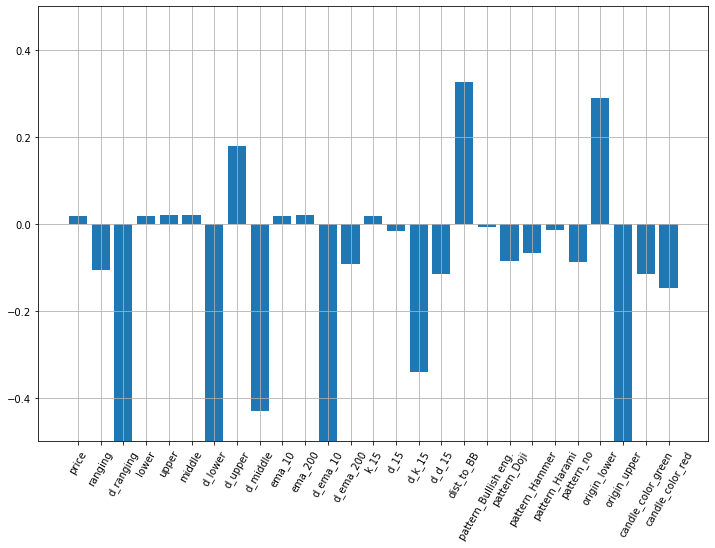

In [44]:
plt.figure(figsize=(12,8))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(np.arange(len(importance)), X_val.columns, rotation=60)
plt.ylim([-0.5,0.5])
plt.grid()
plt.show()

In [45]:
len(importance)

27

In [46]:
# try different solvers for logostic regression
# solvers = {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}
# for solver in solvers:
#     logmodel_solv = LogisticRegression(solver=solver)
#     print(f"Solver : {solver}")
#     score_dataset(logmodel_solv, X_train, X_val, y_train, y_val)

### XG Boost

In [47]:
XGB_basic = XGBClassifier(n_estimators=1000, learning_rate=0.01, random_state=0)

In [48]:
# XGB_basic.fit(X_train, y_train,
#              early_stopping_rounds=5, 
#              eval_set=[(X_val, y_val)], 
#              verbose=False)

In [49]:
print("XG Boost :")
score_dataset(XGB_basic, X_train, X_val, y_train, y_val,
             early_stopping_rounds=10,
             eval_set=[(X_val, y_val)],
             verbose=False)

XG Boost :
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1183
           1       0.60      0.57      0.59       817

    accuracy                           0.67      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.67      0.67      0.67      2000



0.332

In [50]:
#val_preds_XGB = XGB_basic.predict(X_val)

In [51]:
#mae = mean_absolute_error(val_preds_XGB, y_val)

In [52]:
#print(f"MAE for the XG Boost without categorical features: {mae}")

### The best model

According to the classification reports, the best model that predicts succesfull trasdes is happened to be logistic regression.
Now, save this model using `pickle`

In [53]:
# let's train the model again:
logmodel_basic = LogisticRegression(solver='warn')
logmodel_basic.fit(X_train, y_train)


C:\Users\Taras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
# Load pre-trained model:
with open('logregression.pickle', 'wb') as f:
    pickle.dump(logmodel_basic, f)

In [55]:
# Open pre-trained model:
pickle_in = open('logregression.pickle', 'rb')
logmodel_loaded = pickle.load(pickle_in)

In [56]:
# Check if loaded model shows the same results:
score_dataset(logmodel_loaded, X_train, X_val, y_train, y_val)

C:\Users\Taras\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.65      0.89      0.76      1183
           1       0.67      0.32      0.43       817

    accuracy                           0.66      2000
   macro avg       0.66      0.60      0.59      2000
weighted avg       0.66      0.66      0.62      2000



0.3425

<b> Note. </b> `XGBoost` shows better accuracy in general, but it better predicts loosing trades rather than succesfull. 

In [57]:
logmodel_loaded.predict(X_val.iloc[-1])

ValueError: Expected 2D array, got 1D array instead:
array=[1.2510e-05 2.6836e+01 2.5900e-01 1.0610e-05 1.3050e-05 1.1830e-05
 1.0000e-03 0.0000e+00 0.0000e+00 1.2120e-05 9.8000e-06 0.0000e+00
 0.0000e+00 1.8050e+01 1.1040e+01 6.5000e-01 1.8000e-01 4.3010e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 1.0000e+00 0.0000e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [58]:
logmodel_loaded.predict( np.array(X_val.iloc[-1]).reshape(1, -1) )[-1]

0

In [59]:
X_val.iloc[-1]

price                    0.000013
ranging                 26.836000
d_ranging                0.259000
lower                    0.000011
upper                    0.000013
middle                   0.000012
d_lower                  0.001000
d_upper                  0.000000
d_middle                 0.000000
ema_10                   0.000012
ema_200                  0.000010
d_ema_10                 0.000000
d_ema_200                0.000000
k_15                    18.050000
d_15                    11.040000
d_k_15                   0.650000
d_d_15                   0.180000
dist_to_BB               4.301000
pattern_Bullish eng.     0.000000
pattern_Doji             0.000000
pattern_Hammer           0.000000
pattern_Harami           0.000000
pattern_no               1.000000
origin_lower             0.000000
origin_upper             1.000000
candle_color_green       1.000000
candle_color_red         0.000000
Name: 3250, dtype: float64

In [ ]:
[0 for _ in range(27)]